# PrimaryBinaryNN:
A Neural Network Model that uses batched SMOTE upsampling. This is able to detect all of the threats in the dataset which can be passed to a secondary model allowing for a smaller dataset to evaluate. What this means is that we are left only needing to seperate the falsely predicted normal labels from the remaininig data. This is easier than when we get false predictions in both due to the cross-over. The reason is in a real scenario we do not have the actual labels and then it becomes very difficult to actual extract the incorrect predictions when they are on both labels. But when they are just in 1 we can easily extract it.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from Models.models import NNsmote, plot_confusion_matrix, plot_metrics

In [27]:
data = pd.read_csv('Cleaned_full_data.csv')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_26336\2584280520.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [28]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [29]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [30]:
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [31]:
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [ ]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [33]:
X_temp = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=42)
test_attack_cat = X_test['attack_cat']
print('Train:', y_train.value_counts())
print('Test', y_test.value_counts())
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])

Train: label
0    1774933
1     257104
Name: count, dtype: int64
Test label
0    443831
1     64179
Name: count, dtype: int64


In [34]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Number of features.
n_features = X_train_tensor.shape[1]
# The size of the dense layer.
fully_connected_size = 128
# The directory to save the models.
save_dir = './Models/saved_models/'
model1 = NNsmote(n_features=n_features, fc_size=fully_connected_size, device=device, save_dir=save_dir)

In [46]:
# Parameters:
# 1. The dataloader of the training set.
# 2. The learning rate - it is recommended to use lr = 0.05-0.1 as this seems to be able to class all threats.
learning_rate = 0.1
# 3. The number of epochs. With a learning rate of 0.1 it tends to converge on the first epoch. However each epoch yields a different result due to the
# shuffled batches from DataLoader. After training the model for a set amount of epochs a loop can be done to load each epoch iteratively and evaluate to find which
# has the best prediction rate in a confusion matrix.
epochs = 1
# 4. The save factor. 1 means it will save every epoch. 2 would be every second epoch etc.
save_factor = 1
# 5. The number of k-neighbours for the SMOTE upsampling method. Currently SMOTE upsamples all minority classes to the majority class (auto). I have not really tested
# too many variations of this. As you increase the number of neighbours, it also increases the chance at which the process might fail and default back into a normal sample 
# for the batch. With n = 2, the sampling fails rarely but this might be only for one batch in a whole epoch which means it gives it a kind of dynamic sampling.
k_neighbours = 2
# NOTE: To try and test different models a new one needs to be created by running the above code.
model1.run(train_loader, learning_rate, epochs, save_factor, k_neighbours)

Epoch 1/1:  90%|█████████ | 14357/15876 [03:52<00:23, 64.38batch/s]

Error running SMOTE.


Epoch 1/1: 100%|██████████| 15876/15876 [04:16<00:00, 61.80batch/s]

Error running SMOTE.
Epoch [1/1], Train Loss: 0.0242, Train Acc: 0.9914, Train F1: 0.9914


In [52]:
# Only the test loader is required. The same optimiser and criterion are used internally. The optimiser and criterion can also be changed by setting the attribute.
# For Example: model1.criterion = nn.CrossEntropyLoss, or model1.optimizer = ...
model1.test(test_loader)

Testing: 100%|██████████| 3969/3969 [00:11<00:00, 347.08batch/s]

Test Loss: 0.0229, Test Accuracy: 0.9871, Test F1: 0.9876


SMOTE


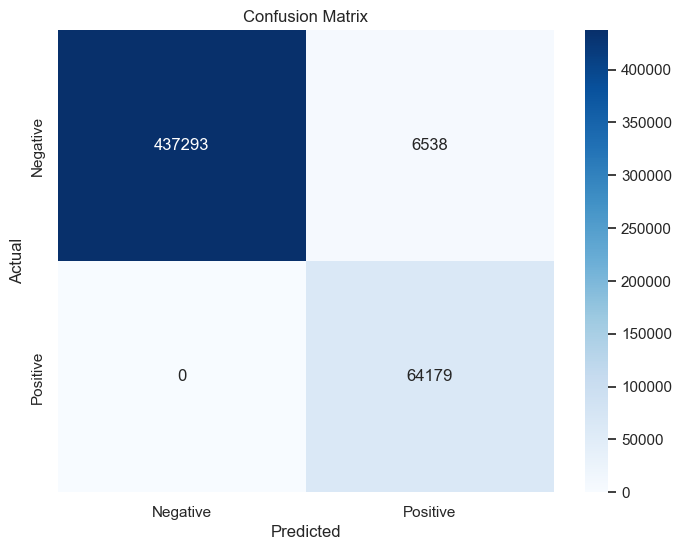

In [53]:
print('SMOTE')
labels = test_dataset.tensors[1]
# The method is imported from models library.
plot_confusion_matrix(labels, model1.test_predicted)

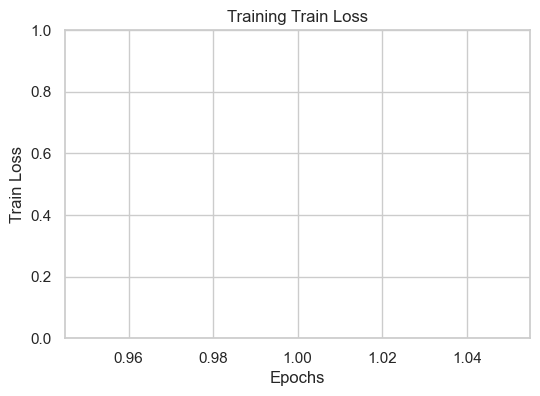

In [54]:
# Plot the saved metrics. The method is imported from the models library.
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")

Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 332.19batch/s]


Test Loss: 0.0229, Test Accuracy: 0.9871, Test F1: 0.9876


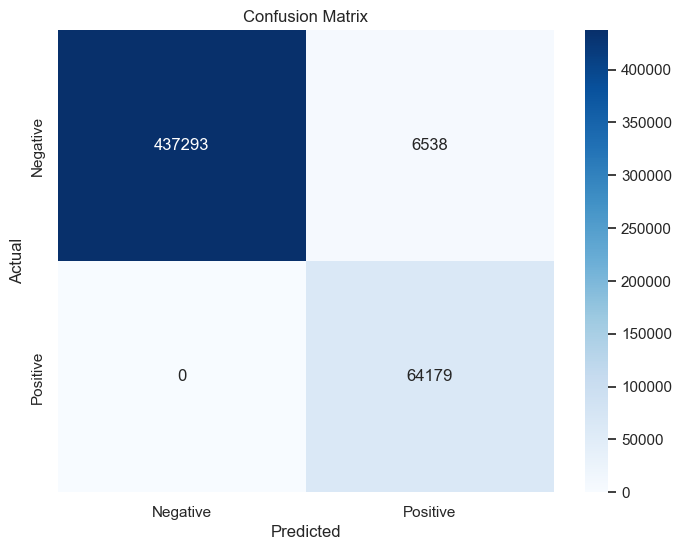

In [55]:
# This section loads each saved epoch and runs the test on it then evaluates it with a confusion matrix. This allows you to easily run multiple saved epochs and omits
# the need for a validation set. Optimally we would choose the lowest epoch but the model tend not to overfit anyway. The range must be set to the number of saved models + 1.
for i in range(1, 2):
    path = f"./Models/saved_models/PB_epoch_{i}.joblib"
    model = model1.load_model(path)
    print(f"Epoch: {i}")
    model.test(test_loader)
    y_pred = np.array(model.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model.test_predicted = []